In [ ]:
#IMPORTANDO BIBLIOTECAS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as stats
from math import sqrt
from scipy.stats import wilcoxon
import string
from scipy.stats import chi2


In [2]:
#1. IMPORTANDO DADOS 
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')

multiplicador = 1   # 1 = metros | 100 = centímetros | 1000 = milímetros
print(f"Usando multiplicador: {multiplicador}\n")

#DATAFRAME DADOS ORIGINAIS (DF_ALTI)
col_list = df_alti.columns.tolist()

#DATAFRAME DAS DIFERENÇAS (DF_DIFF)
trats = col_list[2:]
const = 0.138

df_diff = pd.DataFrame(index=df_alti.index)

for trat in trats:
    df_diff[f"{trat}_diff"] = df_alti[trat] - df_alti['NIV'] + const

# Aplicar multiplicador (MÁGICA AQUI)
df_diff = df_diff * multiplicador

#DATAFRAME DAS DIFERENÇAS EM MODULO (DF_DIFF_ABS)
df_diff_abs = df_diff.abs()

print("\ndf_alti.head():\n", df_alti.head())
print("\ndf_diff.head():\n", df_diff.head())
print("\ndf_diff_abs.head():\n", df_diff_abs.head())

Usando multiplicador: 1


df_alti.head():
    PT       NIV         V1        V2         V3
0   1  804.9540  804.81171  804.8190  804.78698
1   2  804.9360  804.81283  804.8208  804.78687
2   3  804.9375  804.79095  804.8129  804.78312
3   4  804.9375  804.78145  804.8065  804.77104
4   5  804.9090  804.76936  804.7909  804.74439

df_diff.head():
    V1_diff  V2_diff  V3_diff
0 -0.00429   0.0030 -0.02902
1  0.01483   0.0228 -0.01113
2 -0.00855   0.0134 -0.01638
3 -0.01805   0.0070 -0.02846
4 -0.00164   0.0199 -0.02661

df_diff_abs.head():
    V1_diff  V2_diff  V3_diff
0  0.00429   0.0030  0.02902
1  0.01483   0.0228  0.01113
2  0.00855   0.0134  0.01638
3  0.01805   0.0070  0.02846
4  0.00164   0.0199  0.02661


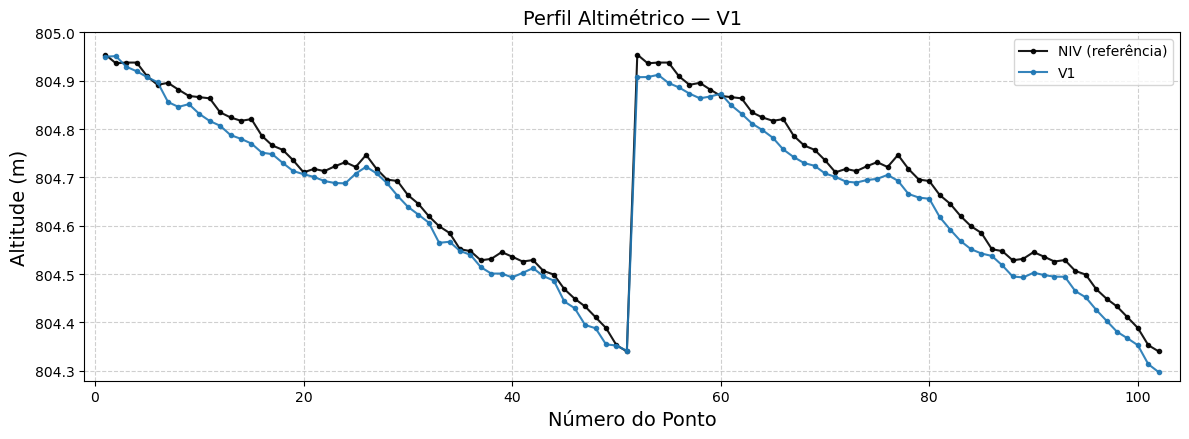

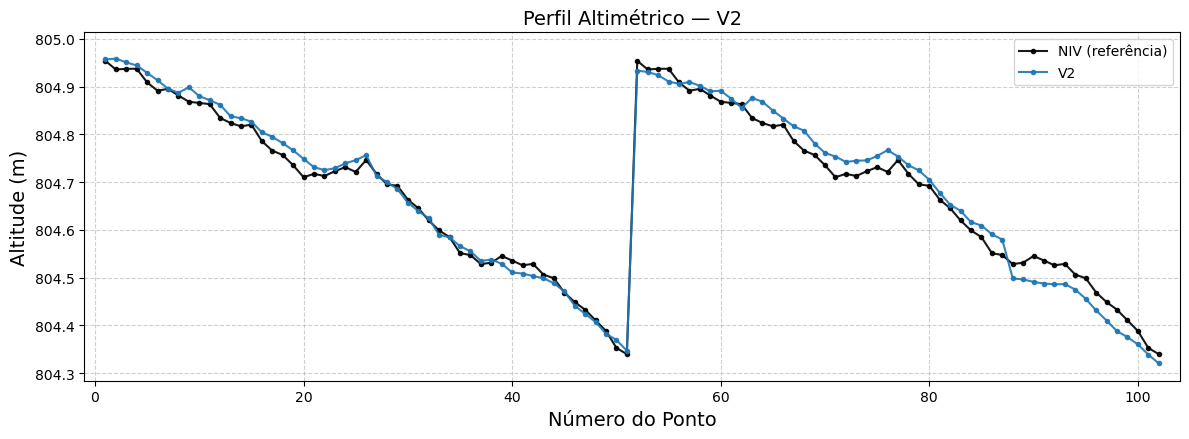

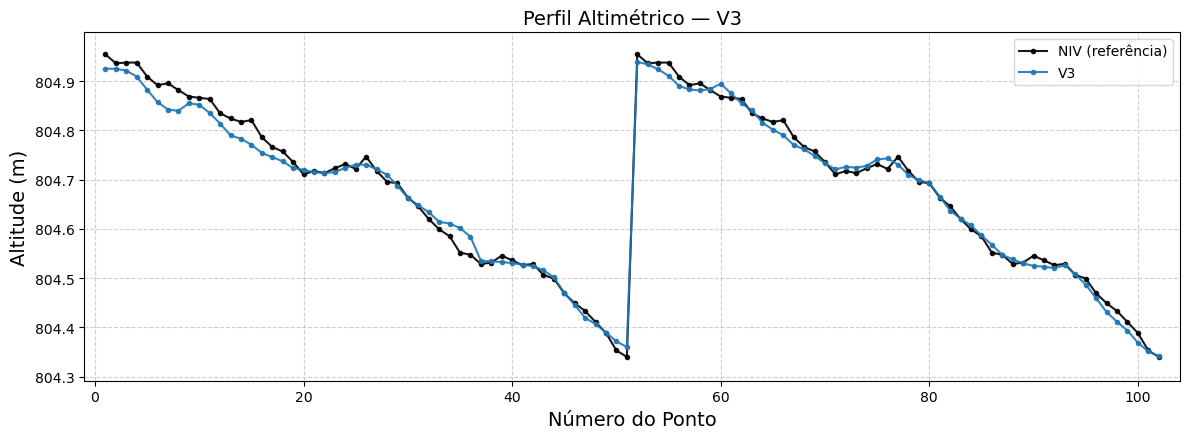

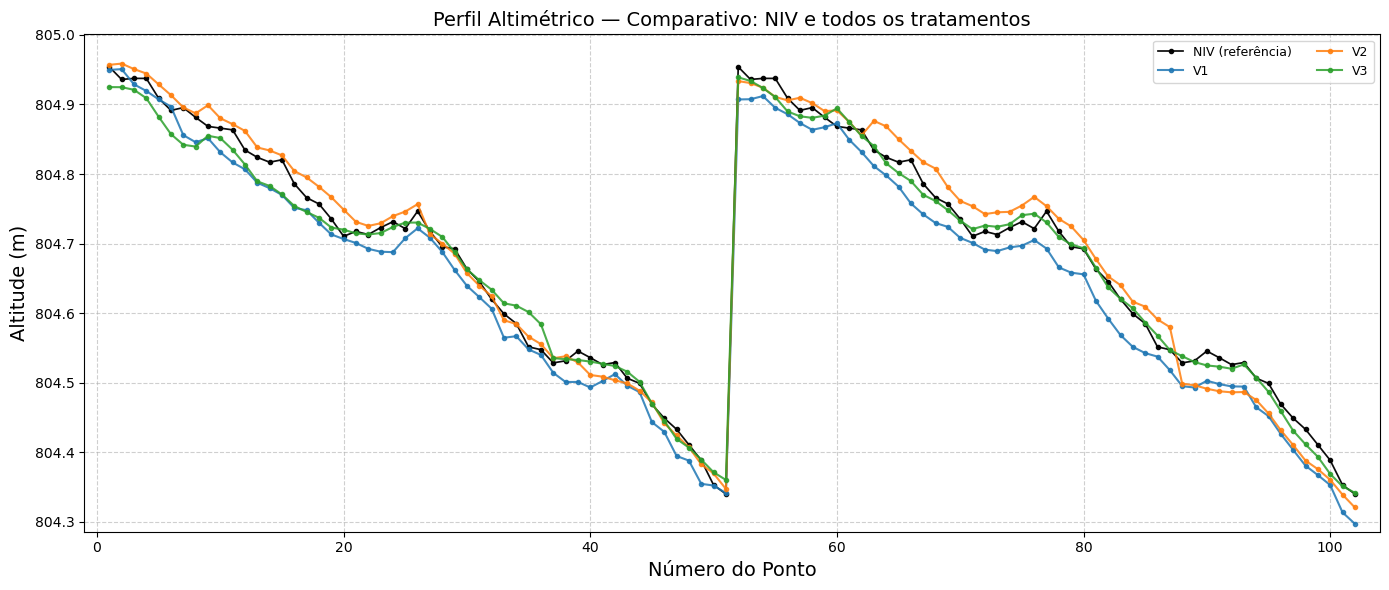

In [3]:
### 2. GRAFICO DE PERFIL
for trat in trats:
    df_alti[trat] = df_alti[trat] + const


# --- VARIÁVEIS DE CONFIGURAÇÃO VISUAL ---

# --- Tamanho das bolinhas ---
markersize_ref = 3      # NIV
markersize_sel = 3      # Tratamento 

# --- Espaçamento / margens manual nos eixos ---
x_margin_frac = 0.02    # fração do eixo X
y_margin_frac = 0.05    # fração do eixo Y
# Se quiser alterar, basta mudar esses valores

# --- FUNÇÕES DE ESCALA ---
def escala_percentil(z, p_low=2, p_high=98, margin_frac=0.05):
    """Define limites verticais com base nos percentis e uma margem relativa."""
    y_low = np.percentile(z, p_low)
    y_high = np.percentile(z, p_high)
    y_range = y_high - y_low if (y_high - y_low) != 0 else 1.0
    ymin = y_low - margin_frac * y_range
    ymax = y_high + margin_frac * y_range
    return ymin, ymax

def escala_combinada(arrays, metodo='percentil', margin_frac=y_margin_frac):
    combined = np.concatenate([np.asarray(a).ravel() for a in arrays])
    if metodo == 'percentil':
        ymin, ymax = escala_percentil(combined, margin_frac=margin_frac)
        return ymin, ymax
    else:
        raise ValueError("Método inválido: use 'percentil'")

# --- FUNÇÃO DE PLOT NIV vs UMA COLUNA ---
def plot_niv_vs_trat(df, trat_col, metodo='percentil', nome=None, save=False):
    ref_col = df.columns[1]  # NIV
    y_ref = df[ref_col].to_numpy()
    y_sel = df[trat_col].to_numpy()
    x = np.arange(1, len(y_ref) + 1)

    # calcula limites considerando ambos os conjuntos
    ymin, ymax = escala_combinada([y_ref, y_sel], metodo=metodo, margin_frac=y_margin_frac)

    fig, ax = plt.subplots(figsize=(12, 4.5))

    # --- Plot referência (NIV) ---
    ax.plot(
        x, y_ref,
        marker='o',
        markersize=markersize_ref,   # <- ajuste tamanho da bolinha aqui
        linestyle='-',
        color='black',
        label=f"{ref_col} (referência)",
        alpha=0.9
    )

    # --- Plot seleção (coluna trat) ---
    ax.plot(
        x, y_sel,
        marker='o',
        markersize=markersize_sel,   # <- ajuste tamanho da bolinha aqui
        linestyle='-',
        color='C0',
        label=f"{trat_col}",
        alpha=0.9
    )

    # --- Margens adicionais nos eixos ---
    x_span = len(x)
    ax.set_xlim(1 - x_margin_frac*x_span, len(x) + x_margin_frac*x_span)
    y_span = ymax - ymin
    ax.set_ylim(ymin - y_margin_frac*y_span, ymax + y_margin_frac*y_span)

    # --- Título, rótulos e grid ---
    titulo = f"Perfil Altimétrico — {trat_col}" if nome is None else nome
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel('Número do Ponto', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    plt.tight_layout()

    if save:
        fname = f"perfil_NIV_vs_{trat_col}.png"
        fig.savefig(fname, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)

# --- Gerar gráficos para cada coluna ---
for trat in trats:
    plot_niv_vs_trat(df_alti, trat, metodo='percentil', save=True)

# --- Gráfico comparativo final: NIV vs todas as colunas ---
def plot_comparativo_todos(df, trats_list, metodo='percentil', save=False):
    ref_col = df.columns[1]
    y_ref = df[ref_col].to_numpy()
    x = np.arange(1, len(y_ref) + 1)

    fig, ax = plt.subplots(figsize=(14, 6))

    # --- NIV ---
    ax.plot(x, y_ref, marker='o', markersize=markersize_ref, linestyle='-', color='black',
            linewidth=1.25, label=f"{ref_col} (referência)", alpha=0.95)

    # --- Todos os tratamentos ---
    colors_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, trat in enumerate(trats_list):
        color = colors_palette[i % len(colors_palette)]
        y = df[trat].to_numpy()
        ax.plot(x, y, marker='o', markersize=markersize_sel, linestyle='-', label=f"{trat}",
                color=color, alpha=0.85)

    # Limites combinados
    arrays = [y_ref] + [df[t].to_numpy() for t in trats_list]
    ymin, ymax = escala_combinada(arrays, metodo=metodo, margin_frac=y_margin_frac)
    x_span = len(x)
    y_span = ymax - ymin
    ax.set_xlim(1 - x_margin_frac*x_span, len(x) + x_margin_frac*x_span)
    ax.set_ylim(ymin - y_margin_frac*y_span, ymax + y_margin_frac*y_span)

    ax.set_title("Perfil Altimétrico — Comparativo: NIV e todos os tratamentos", fontsize=14)
    ax.set_xlabel('Número do Ponto', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(ncol=2, fontsize=9, loc='best')

    plt.tight_layout()
    if save:
        fig.savefig("perfil_comparativo_todos.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Chamada do comparativo
plot_comparativo_todos(df_alti, trats, metodo='percentil', save=True)


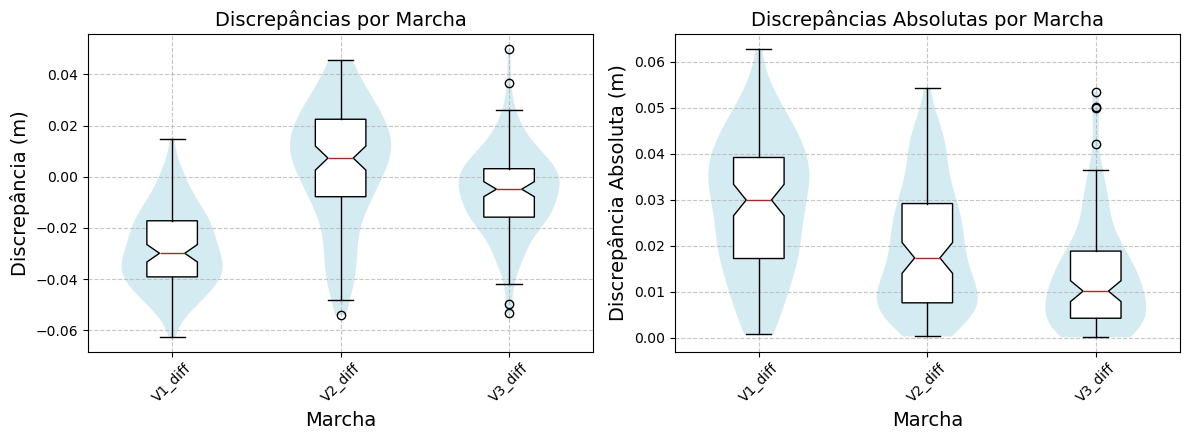

In [4]:
### 3. GRAFICO DE BOXPLOT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# DISCREPANCIAS
data_diff = [df_diff[col] for col in df_diff.columns]
positions_diff = np.arange(1, len(df_diff.columns) + 1)

# VIOLINGRAPH
parts1 = ax1.violinplot(data_diff, positions=positions_diff, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts1['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

# BOXPLOT
ax1.boxplot(data_diff, positions=positions_diff,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax1.set_title('Discrepâncias por Marcha', fontsize=14)
ax1.set_ylabel('Discrepância (m)', fontsize=14)
ax1.set_xlabel('Marcha', fontsize=14)
ax1.set_xticks(positions_diff)
ax1.set_xticklabels(df_diff.columns, rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# DISCREPANCIAS ABSOLUTAS
data_diff_abs = [df_diff_abs[col] for col in df_diff_abs.columns]
positions_abs = list(range(1, len(df_diff.columns) + 1))

parts2 = ax2.violinplot(data_diff_abs, positions=positions_abs, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts2['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

ax2.boxplot(data_diff_abs, positions=positions_abs,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax2.set_title('Discrepâncias Absolutas por Marcha', fontsize=14)
ax2.set_ylabel('Discrepância Absoluta (m)', fontsize=14)
ax2.set_xlabel('Marcha', fontsize=14)
ax2.set_xticks(positions_abs)
ax2.set_xticklabels(df_diff_abs.columns, rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('boxplot_com_fundo_violin.png', dpi=300, bbox_inches='tight')
plt.show()



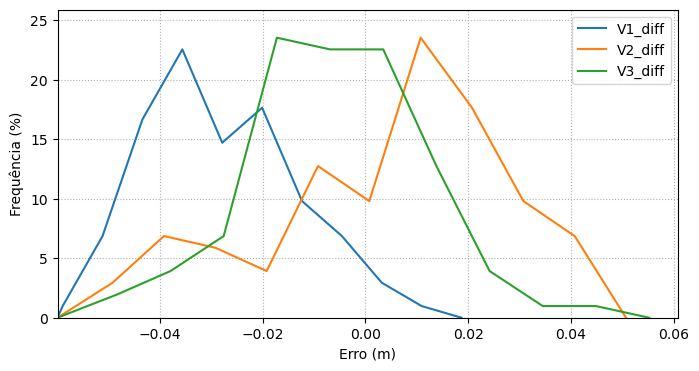

In [ ]:
### 4. GRÁFICO DE DISTRIBUIÇÃO DE FREQUÊNCIA

bins = 10

def CalcHistLin(data, nbins):
    count, bins_values = np.histogram(data, bins=nbins)
    total_count = sum(count)
    percent_value = (count / total_count) * 100
    bins_center = 0.5*(bins_values[:-1] + bins_values[1:])
    return bins_center, percent_value


# Calcula histogramas
bin_v1, freq_v1 = CalcHistLin(df_diff['V1_diff'], bins)
bin_v2, freq_v2 = CalcHistLin(df_diff['V2_diff'], bins)
bin_v3, freq_v3 = CalcHistLin(df_diff['V3_diff'], bins)

# --- Novo: criando ponto inicial correto (xmin_global, 0) ---
xmin_global = min(bin_v1.min(), bin_v2.min(), bin_v3.min())-0.001

# Inserir esse ponto no início das curvas
bin_v1 = np.insert(bin_v1, 0, xmin_global-0.00001)
freq_v1 = np.insert(freq_v1, 0, 0)

bin_v2 = np.insert(bin_v2, 0, xmin_global-0.00001)
freq_v2 = np.insert(freq_v2, 0, 0)

bin_v3 = np.insert(bin_v3, 0, xmin_global-0.00001)
freq_v3 = np.insert(freq_v3, 0, 0)

# --- Criar ponto final artificial ---
def add_final_point(x, y):
    last_x = 2*x[-1] - x[-2]
    x = np.append(x, last_x)
    y = np.append(y, 0)
    return x, y

bin_v1, freq_v1 = add_final_point(bin_v1, freq_v1)
bin_v2, freq_v2 = add_final_point(bin_v2, freq_v2)
bin_v3, freq_v3 = add_final_point(bin_v3, freq_v3)


# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(bin_v1, freq_v1, label='V1_diff')
plt.plot(bin_v2, freq_v2, label='V2_diff')
plt.plot(bin_v3, freq_v3, label='V3_diff')

plt.xlabel('Erro (m)')
plt.ylabel('Frequência (%)')

plt.ylim(0, max(np.concatenate((freq_v1, freq_v2, freq_v3))) * 1.1)
plt.xlim(xmin_global, max(np.concatenate((bin_v1, bin_v2, bin_v3))) * 1.1)

plt.grid(True, linestyle=':')
plt.legend()
plt.show()


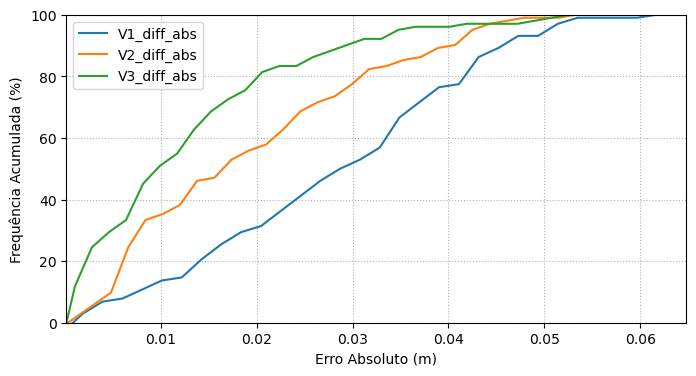

In [ ]:
### 5. FREQUÊNCIA ACUMULADA POR CLASSES

bins = 30

def freq_acumulada_classes(serie, bins):
    # Histograma básico
    counts, bin_edges = np.histogram(serie, bins=bins)
    
    # Frequência percentual por classe
    freq = counts / counts.sum() * 100
    
    # Frequência acumulada
    cum_freq = np.cumsum(freq)
    
    # Centro dos bins
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Inserindo ponto inicial 0%
    bin_centers = np.insert(bin_centers, 0, bin_edges[0])
    cum_freq = np.insert(cum_freq, 0, 0)
    
    return bin_centers, cum_freq


# Gerar curvas
bin_v1c, cum_v1c = freq_acumulada_classes(df_diff_abs['V1_diff'], bins)
bin_v2c, cum_v2c = freq_acumulada_classes(df_diff_abs['V2_diff'], bins)
bin_v3c, cum_v3c = freq_acumulada_classes(df_diff_abs['V3_diff'], bins)


# Plot
plt.figure(figsize=(8,4))

plt.plot(bin_v1c, cum_v1c, label='V1_diff_abs')
plt.plot(bin_v2c, cum_v2c, label='V2_diff_abs')
plt.plot(bin_v3c, cum_v3c, label='V3_diff_abs')

plt.xlabel('Erro Absoluto (m)')
plt.ylabel('Frequência Acumulada (%)')

plt.ylim(0, 100)
plt.xlim(
    min(bin_v1c.min(), bin_v2c.min(), bin_v3c.min()),
    max(bin_v1c.max(), bin_v2c.max(), bin_v3c.max()) * 1.05
)

plt.grid(True, linestyle=':')
plt.legend()
plt.show()


In [ ]:
# 6. TESTE DE NORMALIDADE
import pandas as pd
from scipy.stats import shapiro

# --- FUNÇÃO ---
def testar_normalidade_df(df):
    resultados = []
    for col in df.columns:
        dados = df[col].dropna()  # remove valores nulos
        
        if len(dados) < 8:
            resultados.append((col, None, None, "Amostra muito pequena"))
            continue
        
        stat, p = shapiro(dados)
        resultado = "Normal (p > 0.05)" if p > 0.05 else "Não normal (p < 0.05)"
        resultados.append((col, stat, p, resultado))
    
    # Cria um DataFrame com os resultados
    df_result = pd.DataFrame(resultados, columns=["Coluna", "W", "p", "Resultado"])
    return df_result

# --- EXECUÇÃO ---
df_normalidade = testar_normalidade_df(df_diff)

# --- EXIBIÇÃO ---
print("===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====")
print(df_normalidade)

# --- OPCIONAL: salvar para Excel ---
df_normalidade.to_excel("teste_normalidade_shapiro.xlsx", index=False)



===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====
    Coluna         W         p              Resultado
0  V1_diff  0.985407  0.326118      Normal (p > 0.05)
1  V2_diff  0.964324  0.007429  Não normal (p < 0.05)
2  V3_diff  0.985956  0.357417      Normal (p > 0.05)


In [ ]:

# 7. TESTES DE COMPARAÇÃO DE MÉDIAS (NÃO PARAMÉTRICOS)
# Usando: Teste de Friedman + Testes de Wilcoxon pareados

from scipy.stats import friedmanchisquare, wilcoxon
import pandas as pd

# --- Teste de Friedman (comparação global entre os três grupos) ---
stat_friedman, p_friedman = friedmanchisquare(
    df_diff['V1_diff'],
    df_diff['V2_diff'],
    df_diff['V3_diff']
)

print("\n===== TESTE DE FRIEDMAN =====")
print(f"Estatística Q = {stat_friedman:.6f}")
print(f"p-valor = {p_friedman:.6f}")

if p_friedman < 0.05:
    print("→ Diferença significativa entre os grupos (p < 0.05).")
else:
    print("→ NÃO há diferença significativa entre os grupos (p ≥ 0.05).")

# --- Executa Wilcoxon automaticamente se o Friedman for significativo ---
pares = [
    ('V1', 'V2'),
    ('V1', 'V3'),
    ('V2', 'V3')
]

resultados_wilcoxon = []

if p_friedman < 0.05:
    print("\n===== TESTES DE WILCOXON (PÓS-TESTES) =====")
    for a, b in pares:
        stat_w, p_w = wilcoxon(df_diff[f"{a}_diff"], df_diff[f"{b}_diff"])
        resultado = {
            "Comparação": f"{a} × {b}",
            "Estatística W": stat_w,
            "p-valor": p_w,
            "Conclusão": "Diferença significativa" if p_w < 0.05 else "Sem diferença significativa"
        }
        resultados_wilcoxon.append(resultado)
        print(f"\nComparação {a} × {b}:")
        print(f"  Estatística W = {stat_w:.6f}")
        print(f"  p-valor = {p_w:.6f}")
        print(f"  → {resultado['Conclusão']}")
else:
    print("\nPós-testes de Wilcoxon não realizados (Friedman não significativo).")

# --- Armazenar tudo em um DataFrame (útil para exportar ao relatório) ---
df_resultados = pd.DataFrame(resultados_wilcoxon)
print("\n===== RESUMO DOS TESTES DE WILCOXON =====")
display(df_resultados)



===== TESTE DE FRIEDMAN =====
Estatística Q = 117.725490
p-valor = 0.000000
→ Diferença significativa entre os grupos (p < 0.05).

===== TESTES DE WILCOXON (PÓS-TESTES) =====

Comparação V1 × V2:
  Estatística W = 89.000000
  p-valor = 0.000000
  → Diferença significativa

Comparação V1 × V3:
  Estatística W = 300.500000
  p-valor = 0.000000
  → Diferença significativa

Comparação V2 × V3:
  Estatística W = 1611.000000
  p-valor = 0.000699
  → Diferença significativa

===== RESUMO DOS TESTES DE WILCOXON =====


,Comparação,Estatística W,p-valor,Conclusão
0,V1 × V2,89.0,2.440558e-17,Diferença significativa
1,V1 × V3,300.5,8.189269e-15,Diferença significativa
2,V2 × V3,1611.0,6.991209e-04,Diferença significativa


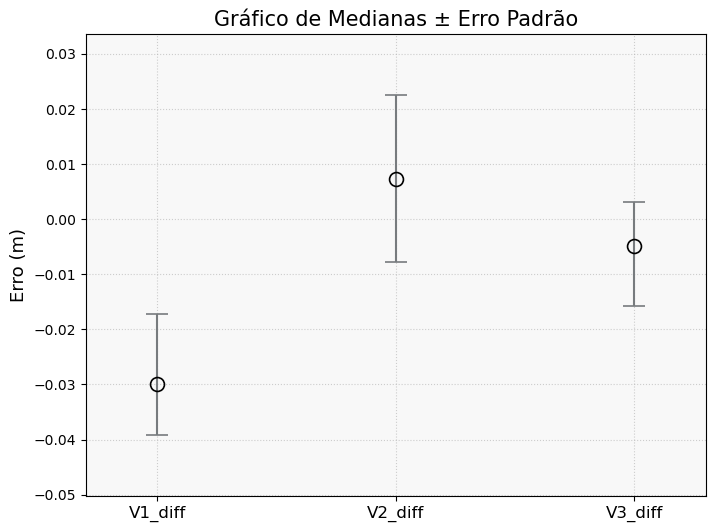

In [ ]:
# 8. GRÁFICO DE MEDIANAS + ERRO PADRÂO

dados = df_diff.copy()

# Estatísticas não-paramétricas
medianas = dados.median()
q1 = dados.quantile(0.25)
q3 = dados.quantile(0.75)
iqr = q3 - q1

plt.figure(figsize=(8,6))
x = np.arange(len(medianas))

colors = ["#000000", "#444444", "#888888"]

plt.errorbar(
    x, medianas,
    yerr=[medianas - q1, q3 - medianas],
    fmt='o',
    markersize=10,
    markeredgewidth=1.2,
    fillstyle='none',
    color='#000000',
    ecolor='#777B7E',
    elinewidth=1.5,
    capsize=8,
    zorder=3
)

plt.xticks(x, medianas.index, fontsize=12)
plt.ylabel("Erro (m)", fontsize=13)
plt.title("Gráfico de Medianas ± Erro Padrão", fontsize=15)

plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.6, zorder=0)
plt.margins(x=0.15, y=0.18)

ax = plt.gca()
ax.set_facecolor("#f8f8f8")

plt.show()


In [ ]:
# 9. MATRIZ DE COMPARAÇÃO MÚLTIPLA (WILCOXON)

df_sinal = df_diff.copy()        # V1_diff, V2_diff, V3_diff
df_abs   = df_diff_abs.copy()    # V1_diff_abs, V2_diff_abs, V3_diff_abs

colunas = df_sinal.columns.tolist()

resultados = []

for i in range(len(colunas)):
    for j in range(i + 1, len(colunas)):

        # --- nomes das colunas ---
        c1 = colunas[i]
        c2 = colunas[j]

        # ============================
        # TESTE WILCOXON — COM SINAL
        # ============================
        w_sinal, p_sinal = stats.wilcoxon(df_sinal[c1], df_sinal[c2])
        concl_sinal = "Diferença significativa" if p_sinal < 0.05 else "Sem diferença"

        # ============================
        # TESTE WILCOXON — ABSOLUTO
        # ============================
        w_abs, p_abs = stats.wilcoxon(df_abs[c1], df_abs[c2])
        concl_abs = "Diferença significativa" if p_abs < 0.05 else "Sem diferença"

        # Guarda tudo em uma única linha
        resultados.append([
            f"{c1} × {c2}", w_sinal, p_sinal, concl_sinal,
            f"{c1}_abs × {c2}_abs", w_abs, p_abs, concl_abs
        ])

# Converte para DataFrame
tabela_wilcoxon = pd.DataFrame(
    resultados,
    columns=[
        "Comparação (sinal)", "W (sinal)", "p-valor (sinal)", "Conclusão (sinal)",
        "Comparação (abs)", "W (abs)", "p-valor (abs)", "Conclusão (abs)"
    ]
)

print("===== MATRIZ DE COMPARAÇÃO MÚLTIPLA — WILCOXON (SINAL + ABS) =====")
display(tabela_wilcoxon)



===== MATRIZ DE COMPARAÇÃO MÚLTIPLA — WILCOXON (SINAL + ABS) =====


,Comparação (sinal),W (sinal),p-valor (sinal),Conclusão (sinal),Comparação (abs),W (abs),p-valor (abs),Conclusão (abs)
0,V1_diff × V2_diff,89.0,2.440558e-17,Diferença significativa,V1_diff_abs × V2_diff_abs,1284.0,7.411706e-06,Diferença significativa
1,V1_diff × V3_diff,300.5,8.189269e-15,Diferença significativa,V1_diff_abs × V3_diff_abs,708.5,1.527157e-10,Diferença significativa
2,V2_diff × V3_diff,1611.0,6.991209e-04,Diferença significativa,V2_diff_abs × V3_diff_abs,1563.0,3.849987e-04,Diferença significativa


In [ ]:
# 10. TESTE DE NEMENYI


# ---------- Função para calcular o Nemenyi ----------
def nemenyi_pairwise(df):

    k = df.shape[1]      # número de métodos
    n = df.shape[0]      # número de blocos

    # Rankings linha a linha
    rankings = df.rank(axis=1)
    R = rankings.mean()

    # Tabela de valores críticos (α = 0.05)
    q_criticos = {3: 2.343, 4: 2.569, 5: 2.728}
    q = q_criticos[k]

    # Critical Difference
    CD = q * sqrt(k*(k+1)/(6*n))

    colunas = df.columns.tolist()
    resultados = []

    # Comparações i < j
    for i in range(len(colunas)):
        for j in range(i + 1, len(colunas)):
            c1 = colunas[i]
            c2 = colunas[j]

            diff = abs(R[c1] - R[c2])
            sig = "Significativo" if diff > CD else "Não significativo"

            resultados.append([f"{c1} × {c2}", diff, sig])

    return CD, resultados

# 4A. Rodar para os dados COM SINAL

df_sinal = df_diff.copy()
CD_sinal, resultados_sinal = nemenyi_pairwise(df_sinal)

# 4B. Rodar para dados ABSOLUTOS

df_abs = df_diff_abs.copy()
CD_abs, resultados_abs = nemenyi_pairwise(df_abs)



# Unir as tabelas lado a lado
# Garantir mesmo número de linhas
tabela_sinal = pd.DataFrame(resultados_sinal, 
                            columns=["Comparação (sinal)", "Dif. Ranking (sinal)", "Conclusão (sinal)"])

tabela_abs = pd.DataFrame(resultados_abs, 
                          columns=["Comparação (abs)", "Dif. Ranking (abs)", "Conclusão (abs)"])

tabela_final = pd.concat([tabela_sinal, tabela_abs], axis=1)

print("===== TESTE DE NEMENYI — COM SINAL × ABS =====\n")
print(f"Critical Difference (sinal): {CD_sinal:.5f}")
print(f"Critical Difference (abs):   {CD_abs:.5f}\n")

display(tabela_final)


===== TESTE DE NEMENYI — COM SINAL × ABS =====

Critical Difference (sinal): 0.32809
Critical Difference (abs):   0.32809



,Comparação (sinal),Dif. Ranking (sinal),Conclusão (sinal),Comparação (abs),Dif. Ranking (abs),Conclusão (abs)
0,V1_diff × V2_diff,1.431373,Significativo,V1_diff × V2_diff,0.607843,Significativo
1,V1_diff × V3_diff,1.156863,Significativo,V1_diff × V3_diff,0.980392,Significativo
2,V2_diff × V3_diff,0.274510,Não significativo,V2_diff × V3_diff,0.372549,Significativo


In [ ]:

# 11.MÉTODO DAS LETRINHAS — WILCOXON

alpha = 0.05

# --------------------------------
# 1. Preparação dos dados (com sinal)
# --------------------------------
df = df_diff.copy()    # <<<<< usa V1_diff, V2_diff, V3_diff

# Estatísticas descritivas e ordenação por média
desc = df.mean().to_frame(name="mean")
desc["sig_dif"] = ""  # coluna que guardará as letras
desc = desc.sort_values(by="mean")

# lista dos tratamentos ordenados
l_trat = desc.index.tolist()

# lista de letras
letras = list(string.ascii_lowercase)
nl = 0

# Atribui a primeira letra ao menor tratamento
desc.loc[l_trat[0], "sig_dif"] += letras[nl]


# --------------------------------
# Função que realiza Wilcoxon entre dois tratamentos ordenados
# --------------------------------
def letter(x, y):
    col1 = l_trat[x]
    col2 = l_trat[y]
    stat, p = wilcoxon(df[col1], df[col2])
    
    if p > alpha:
        return "h0"   # NÃO há diferença → mesma letra
    else:
        return "h1"   # HÁ diferença → nova letra


# --------------------------------
# 2. Atribuição das letras seguindo a lógica original
# --------------------------------
for i in range(len(l_trat) - 1):
    resultado = letter(i, i + 1)

    if resultado == "h0":
        # mesma letra
        desc.loc[l_trat[i + 1], "sig_dif"] += letras[nl]
    else:
        # letra nova
        nl += 1
        desc.loc[l_trat[i + 1], "sig_dif"] += letras[nl]


# --------------------------------
# 3. Resultado final
# --------------------------------
print("===== LETRINHAS (WILCOXON) — DIFERENÇAS COM SINAL =====")
display(desc)


===== LETRINHAS (WILCOXON) — DIFERENÇAS COM SINAL =====


,mean,sig_dif
V1_diff,-0.028216,a
V3_diff,-0.005737,b
V2_diff,0.004478,c


In [ ]:
# 12. LETRINHAS — TESTE DE WILCOXON (SINAL e ABSOLUTO)

alpha = 0.05

# =====================================================
# Função genérica: calcula as letras usando Wilcoxon
# =====================================================
def wilcoxon_letras(df_base):
    """
    df_base: dataframe contendo colunas como V1_diff, V2_diff, ...
    Retorna um DataFrame com média e letra atribuída.
    """

    # 1) Estatísticas + ordenação
    desc = df_base.mean().to_frame(name="mean")
    desc["letra"] = ""
    desc = desc.sort_values(by="mean")    

    # Lista de tratamentos na ordem crescente
    l_trat = desc.index.tolist()

    # Letras sequenciais (a, b, c, d...)
    letras = list(string.ascii_lowercase)
    nl = 0

    # Primeira letra para o menor
    desc.loc[l_trat[0], "letra"] += letras[nl]

    # Função Wilcoxon entre dois tratamentos adjacentes
    def compara(i, j):
        stat, p = wilcoxon(df_base[l_trat[i]], df_base[l_trat[j]])
        return "h0" if p > alpha else "h1"

    # 2) Atribuição seguindo a lógica original
    for i in range(len(l_trat) - 1):
        test = compara(i, i + 1)

        if test == "h0":
            desc.loc[l_trat[i + 1], "letra"] += letras[nl]
        else:
            nl += 1
            desc.loc[l_trat[i + 1], "letra"] += letras[nl]

    return desc


# =====================================================
# 1. Letrinhas — Diferenças com SINAL
# =====================================================
desc_sinal = wilcoxon_letras(df_diff)
desc_sinal = desc_sinal.rename(
    columns={"mean": "mean_sinal", "letra": "letra_sinal"}
)

print("===== Wilcoxon — Letrinhas (com sinal) =====")
display(desc_sinal)


# =====================================================
# 2. Letrinhas — Diferenças ABSOLUTAS
# =====================================================
desc_abs = wilcoxon_letras(df_diff_abs)
desc_abs = desc_abs.rename(
    columns={"mean": "mean_abs", "letra": "letra_abs"}
)

print("===== Wilcoxon — Letrinhas (absoluto) =====")
display(desc_abs)



===== Wilcoxon — Letrinhas (com sinal) =====


,mean_sinal,letra_sinal
V1_diff,-0.028216,a
V3_diff,-0.005737,b
V2_diff,0.004478,c


===== Wilcoxon — Letrinhas (absoluto) =====


,mean_abs,letra_abs
V3_diff,0.013487,a
V2_diff,0.019741,b
V1_diff,0.028727,c


In [ ]:
# 13.MÉTODO DAS LETRINHAS — NEMENYI

alpha = 0.05

df = df_diff.copy()
k = df.shape[1]
n = df.shape[0]

# -----------------------------
# Ranking médio
# -----------------------------
rankings = df.rank(axis=1)
R = rankings.mean()     # ranking médio de cada coluna

# -----------------------------
# Critical Difference (CD)
# -----------------------------
q_crit = {3: 2.343, 4: 2.569, 5: 2.728}
q = q_crit[k]

CD = q * sqrt(k*(k+1)/(6*n))

# -----------------------------
# Preparar tabela ordenada
# -----------------------------
desc = R.to_frame(name="mean_rank")
desc["sig_dif"] = ""
desc = desc.sort_values(by="mean_rank")

l_trat = desc.index.tolist()

# -----------------------------
# Letras (a, b, c…)
# -----------------------------
letras = list(string.ascii_lowercase)
nl = 0

# primeiro recebe letra "a"
desc.loc[l_trat[0], "sig_dif"] += letras[nl]

# -----------------------------
# Função de comparação estilo Nemenyi
# -----------------------------
def letter_nemenyi(i, j):
    diff = abs(R[l_trat[i]] - R[l_trat[j]])
    if diff <= CD:
        return "h0"      # mesma letra
    else:
        return "h1"      # diferença significativa


# -----------------------------
# Aplicando o sistema das letrinhas
# -----------------------------
for i in range(len(l_trat) - 1):
    resultado = letter_nemenyi(i, i+1)
    
    if resultado == "h0":
        desc.loc[l_trat[i+1], "sig_dif"] += letras[nl]
    else:
        nl += 1
        desc.loc[l_trat[i+1], "sig_dif"] += letras[nl]

# -----------------------------
# Resultado final
# -----------------------------
print("===== LETRINHAS — NEMENYI (DIFERENÇAS COM SINAL) =====")
display(desc)
print(f"\nCritical Difference (CD): {CD:.5f}")


===== LETRINHAS — NEMENYI (DIFERENÇAS COM SINAL) =====


,mean_rank,sig_dif
V1_diff,1.137255,a
V3_diff,2.294118,b
V2_diff,2.568627,b



Critical Difference (CD): 0.32809


In [ ]:
# 14.MÉTODO DAS LETRINHAS — NEMENYI (ABSOLUTO)

df = df_diff_abs.copy()
k = df.shape[1]
n = df.shape[0]

# Ranking médio
rankings = df.rank(axis=1)
R = rankings.mean()

# Critical Difference
q = q_crit[k]
CD = q * sqrt(k*(k+1)/(6*n))

# Tabela ordenada
desc_abs = R.to_frame(name="mean_rank")
desc_abs["sig_dif"] = ""
desc_abs = desc_abs.sort_values(by="mean_rank")

l_trat = desc_abs.index.tolist()

letras = list(string.ascii_lowercase)
nl = 0

desc_abs.loc[l_trat[0], "sig_dif"] += letras[nl]

# Função de comparação
def letter_nemenyi_abs(i, j):
    diff = abs(R[l_trat[i]] - R[l_trat[j]])
    if diff <= CD:
        return "h0"
    else:
        return "h1"

# Aplicando
for i in range(len(l_trat) - 1):
    resultado = letter_nemenyi_abs(i, i+1)

    if resultado == "h0":
        desc_abs.loc[l_trat[i+1], "sig_dif"] += letras[nl]
    else:
        nl += 1
        desc_abs.loc[l_trat[i+1], "sig_dif"] += letras[nl]

print("===== LETRINHAS — NEMENYI (DIFERENÇAS ABSOLUTAS) =====")
display(desc_abs)
print(f"\nCritical Difference (CD): {CD:.5f}")


===== LETRINHAS — NEMENYI (DIFERENÇAS ABSOLUTAS) =====


,mean_rank,sig_dif
V3_diff,1.549020,a
V2_diff,1.921569,b
V1_diff,2.529412,c



Critical Difference (CD): 0.32809


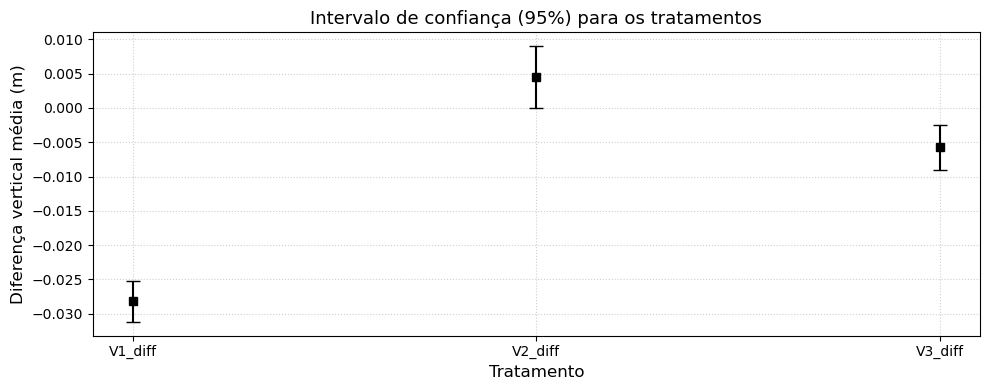

In [ ]:
# 15.GRÁFICO DE MÉDIAS COM INTERVALO DE CONFIANÇA

df = df_diff.copy()

# --------------------------------------------
# Função para intervalo de confiança 95%
# IC = média ± t * (desvio_padrao / sqrt(n))
# --------------------------------------------
def IC95(vetor):
    vetor = np.array(vetor)
    mean = np.mean(vetor)
    sd = np.std(vetor, ddof=1)
    n = len(vetor)
    t = 1.96   # aproximação para 95% (n grande)
    erro = t * sd / sqrt(n)
    return mean, erro


# Cálculo para cada conjunto
tratamentos = df.columns.tolist()
medias = []
erros  = []

for col in tratamentos:
    m, e = IC95(df[col])
    medias.append(m)
    erros.append(e)


# --------------------------------------------
# Plot
# --------------------------------------------
plt.figure(figsize=(10,4))

x = np.arange(len(tratamentos))

plt.errorbar(
    x, medias, yerr=erros,
    fmt='s', markersize=6, linewidth=1.5,
    capsize=5, color='black'
)

plt.xticks(x, tratamentos)
plt.xlabel("Tratamento", fontsize=12)
plt.ylabel("Diferença vertical média (m)", fontsize=12)

plt.grid(True, linestyle=':', alpha=0.6)

plt.title("Intervalo de confiança (95%) para os tratamentos", fontsize=13)
plt.tight_layout()
plt.show()


DECRETO Nº 89.817, DE 20 DE JUNHO DE 1984

Padrão de Exatidão Cartográfica é um indicador estatístico de dispersão, relativo a 90% de probabilidade, que define a exatidão de trabalhos cartográficos.
Classe	EP_alt (m) = fator × equidistância
A	1/6 × equidistância
B	1/3 × equidistância
C	2/5 × equidistância
D	1/2 × equidistância

Ou seja, para equidistância = 1 m:

Classe	EP_alt (m)
A	0.1667
B	0.3333
C	0.4000
D	0.5000

Teste X² = (formula)

Sendo α = 0,10 (10%) - Padrão da Lei
    → Nível de significancia

Escala	Classe	EP Terreno (m)
1:700	A	0.119
	B	0.21
	C	0.35
	D	0.42
1:1000	A	0.170
	B	0.30
	C	0.50
	D	0.60
1:2000	A	0.340
	B	0.60
	C	1.00
	D	1.20

In [ ]:
# 16. PEC ALTIMÉTRICO — AUTOMÁTICO POR EQUIDISTÂNCIA

# ------------------------------------------------------
# 1) CONFIGURAÇÃO 
# ------------------------------------------------------
equid = 0.1    # Equidistancia
alpha = 0.10   # nível de significância

# ------------------------------------------------------
# 2) DATASET USADO (diferenças com sinal)
# ------------------------------------------------------
df = df_diff.copy()          # V1_diff, V2_diff, V3_diff
erro = df.mean(axis=1)

# Vetor com TODOS os erros de todos os métodos combinados
# (ou você pode aplicar sensor por sensor, se preferir)
erros_concat = pd.concat([df[c] for c in df.columns], axis=0)
erros = erros_concat.values
n = len(erros)

# ------------------------------------------------------
# 3) TABELA OFICIAL PEC (Equidistância → EP_alt)
# ------------------------------------------------------
pec_classes = pd.DataFrame({
    "Classe": ["A", "B", "C", "D"],
    "Fator_EP": [1/6, 1/3, 2/5, 1/2]  # fatores oficiais PEC Altimetria
})

# EP absoluto para cada classe
pec_classes["EP_alt"] = pec_classes["Fator_EP"] * equid

# ------------------------------------------------------
# 4) CÁLCULO DO QUI-QUADRADO PARA CADA CLASSE
# ------------------------------------------------------
chi_critico = chi2.ppf(1 - alpha, df=n - 1)

chi_calculado = []
conclusoes = []

for EP in pec_classes["EP_alt"]:
    chi_val = np.sum((erros / EP)**2)
    chi_calculado.append(chi_val)

    conclusoes.append("ATENDE" if chi_val < chi_critico else "NÃO ATENDE")

pec_classes["χ²_calculado"] = chi_calculado
pec_classes["χ²_critico"] = chi_critico
pec_classes["Conclusão"] = conclusoes

# ------------------------------------------------------
# 5) RESULTADO FINAL
# ------------------------------------------------------
print("===== CLASSIFICAÇÃO PEC ALTIMÉTRICA =====")
display(pec_classes)


===== CLASSIFICAÇÃO PEC ALTIMÉTRICA =====


,Classe,Fator_EP,EP_alt,χ²_calculado,χ²_critico,Conclusão
0,A,0.166667,0.016667,701.185842,337.049292,NÃO ATENDE
1,B,0.333333,0.033333,175.296461,337.049292,ATENDE
2,C,0.400000,0.040000,121.733653,337.049292,ATENDE
3,D,0.500000,0.050000,77.909538,337.049292,ATENDE
